# FINAL PROJECT U-NET IMPLEMENTATION

In [1]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import imageio
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import tensorflow as tf
import numpy as np

from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate

In [3]:
# Define the base path
path = ''

# Create paths for image and mask directories
image_path = os.path.join(path, '../CM3070 FYP/dataA/dataA/CameraRGB/')
mask_path = os.path.join(path, '../CM3070 FYP/dataA/dataA/CameraSeg/')

# Get lists of images and masks
image_list = os.listdir(image_path)
mask_list = os.listdir(mask_path)

# Display the first three items in the image list
image_list[:3]

['02_00_000.png', '02_00_001.png', '02_00_010.png']

In [4]:
# Display the first three items in the mask list
mask_list[:3]

['02_00_000.png', '02_00_001.png', '02_00_010.png']

In [5]:
#Path + List
image_list = [image_path+i for i in image_list]
mask_list = [mask_path+i for i in mask_list]
image_list[:3]

['../CM3070 FYP/dataA/dataA/CameraRGB/02_00_000.png',
 '../CM3070 FYP/dataA/dataA/CameraRGB/02_00_001.png',
 '../CM3070 FYP/dataA/dataA/CameraRGB/02_00_010.png']

In [6]:
#Sort the list 
image_list = sorted(image_list)
mask_list = sorted(mask_list)

print("number of images is : {} ".format(len(image_list)))
image_list[:3]

number of images is : 1000 


['../CM3070 FYP/dataA/dataA/CameraRGB/02_00_000.png',
 '../CM3070 FYP/dataA/dataA/CameraRGB/02_00_001.png',
 '../CM3070 FYP/dataA/dataA/CameraRGB/02_00_010.png']

(600, 800, 3)
(600, 800, 3)


Text(0.5, 1.0, 'Mask')

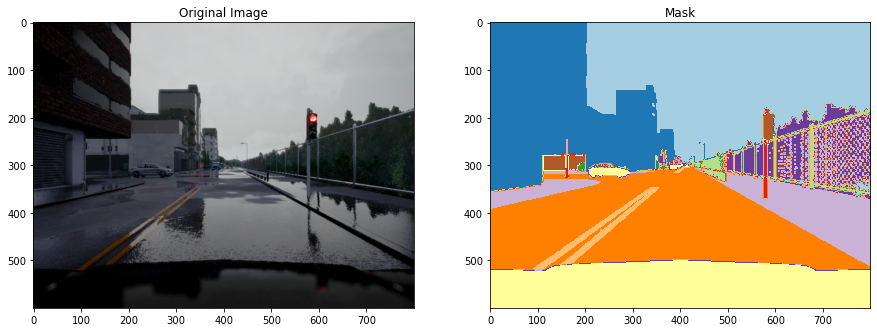

In [7]:
n = 11 # you can chose any index 
img  = imageio.imread(image_list[n])
print(img.shape)
mask = imageio.imread(mask_list[n])
print(mask.shape)

mask = np.array([max(mask[i, j]) for i in range(mask.shape[0]) for j in range(mask.shape[1])]).reshape(img.shape[0], img.shape[1])

# now let's plot 
fig ,arr  = plt.subplots(1,2,figsize=(15,10))
arr[0].imshow(img)
arr[0].set_title('Original Image')
arr[1].imshow(mask, cmap='Paired')
arr[1].set_title('Mask')

                          The Original image and the Mask is visualized side by side


In [8]:
image_list_dataset = tf.data.Dataset.list_files(image_list ,shuffle=False)
mask_list_dataset = tf.data.Dataset.list_files(mask_list , shuffle=False)

These lines create two TensorFlow Dataset objects, image_list_dataset and mask_list_dataset, by using the tf.data.Dataset.list_files() function. 

The shuffle=False argument means that the order of file paths won't be shuffled when creating the dataset.

These datasets are useful for iterating through the file paths and loading the actual image and mask data later.

In [9]:
images_filenames = tf.constant(image_list)
masks_filenames = tf.constant(mask_list)

These lines create TensorFlow constant tensors, images_filenames and masks_filenames, containing the file paths to the images and masks, respectively. 

In [10]:
images_filenames[:5]

<tf.Tensor: shape=(5,), dtype=string, numpy=
array([b'../CM3070 FYP/dataA/dataA/CameraRGB/02_00_000.png',
       b'../CM3070 FYP/dataA/dataA/CameraRGB/02_00_001.png',
       b'../CM3070 FYP/dataA/dataA/CameraRGB/02_00_010.png',
       b'../CM3070 FYP/dataA/dataA/CameraRGB/02_00_011.png',
       b'../CM3070 FYP/dataA/dataA/CameraRGB/02_00_020.png'], dtype=object)>

In [11]:
masks_filenames[:5]

<tf.Tensor: shape=(5,), dtype=string, numpy=
array([b'../CM3070 FYP/dataA/dataA/CameraSeg/02_00_000.png',
       b'../CM3070 FYP/dataA/dataA/CameraSeg/02_00_001.png',
       b'../CM3070 FYP/dataA/dataA/CameraSeg/02_00_010.png',
       b'../CM3070 FYP/dataA/dataA/CameraSeg/02_00_011.png',
       b'../CM3070 FYP/dataA/dataA/CameraSeg/02_00_020.png'], dtype=object)>

In [12]:
dataset = tf.data.Dataset.from_tensor_slices((images_filenames
                                              ,masks_filenames))
for image,mask in dataset.take(1) : 
    print(image)
    print(mask)

tf.Tensor(b'../CM3070 FYP/dataA/dataA/CameraRGB/02_00_000.png', shape=(), dtype=string)
tf.Tensor(b'../CM3070 FYP/dataA/dataA/CameraSeg/02_00_000.png', shape=(), dtype=string)


## Unit-Testing done in Unit-Testing.ipynb for process_path and preprocess


In [13]:
# Function to process image and mask files
def process_path(image_path, mask_path):
    # Read image and mask files
    img = tf.io.read_file(image_path)
    mask = tf.io.read_file(mask_path)
    
    # Decode the PNG data with three color channels
    img = tf.image.decode_png(img, channels=3)
    mask = tf.image.decode_png(mask, channels=3)
    
    # Normalize image values to the range [0, 1]
    img = tf.image.convert_image_dtype(img, tf.float32)
    
    # Create a single-channel mask by taking the maximum value across channels
    mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)
    
    return img, mask

# Function to preprocess input image and mask
def preprocess(image, mask):
    # Resize input image and mask to 96x128 pixels using nearest-neighbor method
    input_image = tf.image.resize(image, (96, 128), method='nearest')
    input_mask = tf.image.resize(mask, (96, 128), method='nearest')
    
    return input_image, input_mask


In [14]:
# Apply the 'process_path' function to each element in the dataset and create a new dataset.
image_ds = dataset.map(process_path)
# Display information about the 'image_ds' dataset.
print(image_ds)
# Apply the 'preprocess' function to each element in 'image_ds' to create a processed image dataset.
processed_image_ds = image_ds.map(preprocess)


<MapDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.uint8, name=None))>


## Defining Architecture of my Convolutional Neural Network (CNN)

### U-NET

In [15]:
def conv_block(inputs=None, n_filters=32, dropout_prob=0, max_pooling=True):
    # First convolutional layer
    conv1 = Conv2D(
        filters=n_filters,
        kernel_size=3,
        activation='relu',
        padding='same',
        kernel_initializer=tf.keras.initializers.HeNormal()
    )(inputs)
    
    # Second convolutional layer
    conv2 = Conv2D(
        filters=n_filters,
        kernel_size=3,
        activation='relu',
        padding='same',
        kernel_initializer=tf.keras.initializers.HeNormal()
    )(conv1)
    
    # Apply dropout if specified
    if dropout_prob > 0:
        conv2 = Dropout(dropout_prob)(conv2)
    
    # Apply max-pooling if specified, otherwise keep the previous layer
    if max_pooling:
        next_layer = MaxPooling2D(pool_size=(2, 2))(conv2)
    else:
        next_layer = conv2
    
    # Preserve the intermediate feature map for skip connections
    skip_connection = conv2
    
    return next_layer, skip_connection


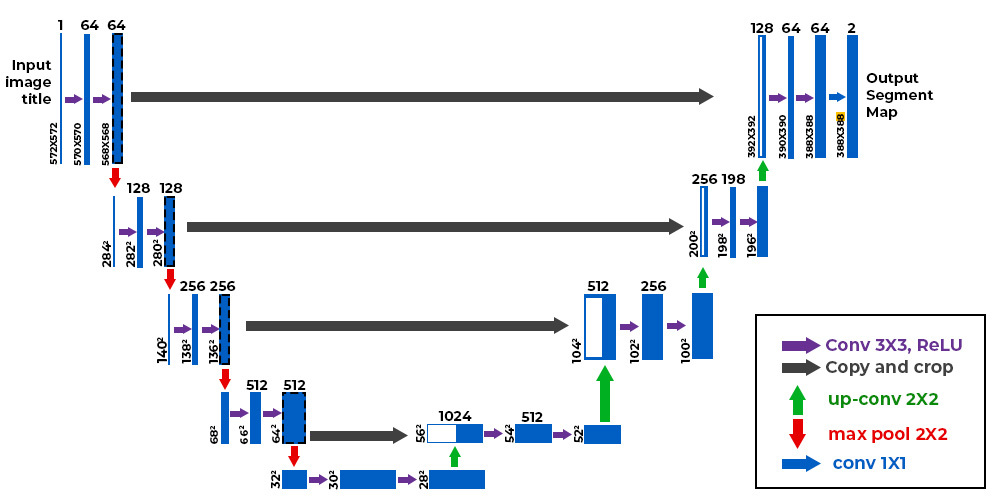

Create a function for an encoding block. This function will provide the next layer's output and the skip connection's output for the corresponding block in the model.

Create a function for a decoding block. This function will combine the skip-connection input with the previous layer, perform necessary processing, and produce an output.

Build a model by utilizing the outputs from both the encoding and decoding blocks.

In [16]:
def upsampling_block(expansive_input, contractive_input, n_filters=32):
    # Upsampling using Conv2DTranspose
    upsampled = Conv2DTranspose(
        filters=n_filters,
        kernel_size=3,
        strides=(2, 2),
        padding='same'
    )(expansive_input)
    
    # Concatenate the upsampled output with the contractive input
    merged = concatenate([upsampled, contractive_input], axis=3)
    
    # Apply two convolutional layers with ReLU activation
    conv1 = Conv2D(
        filters=n_filters,
        kernel_size=3,
        activation='relu',
        padding='same',
        kernel_initializer=tf.keras.initializers.HeNormal()
    )(merged)
    
    conv2 = Conv2D(
        filters=n_filters,
        kernel_size=3,
        activation='relu',
        padding='same',
        kernel_initializer=tf.keras.initializers.HeNormal()
    )(conv1)
    
    return conv2


In [17]:
def unet_model(input_size=(96, 128, 3), n_filters=32, n_classes=23):
    # Define the input layer
    inputs = Input(input_size)
    
    # Contracting path
    cblock1_output, cblock1_skip = conv_block(inputs, n_filters)
    cblock2_output, cblock2_skip = conv_block(cblock1_output, 2 * n_filters)
    cblock3_output, cblock3_skip = conv_block(cblock2_output, 4 * n_filters)
    cblock4_output, cblock4_skip = conv_block(cblock3_output, 8 * n_filters, dropout_prob=0.3) 
    cblock5_output, _ = conv_block(cblock4_output, 16 * n_filters, dropout_prob=0.3, max_pooling=None)     
    
    # Expanding path
    ublock6_output = upsampling_block(cblock5_output, cblock4_skip, 8 * n_filters)
    ublock7_output = upsampling_block(ublock6_output, cblock3_skip, n_filters * 4)
    ublock8_output = upsampling_block(ublock7_output, cblock2_skip, n_filters * 2)
    ublock9_output = upsampling_block(ublock8_output, cblock1_skip, n_filters)

    # Final convolution layers
    conv9 = Conv2D(n_filters,
                   3,
                   activation='relu',
                   padding='same',
                   kernel_initializer='he_normal')(ublock9_output)
    
    conv10 = Conv2D(n_classes, kernel_size=1, padding='same')(conv9)
    
    # Create the U-Net model
    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model


In [18]:
img_height = 96
img_width = 128
num_channels = 3

unet = unet_model((img_height, img_width, num_channels))

In [19]:
unet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 96, 128, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 96, 128, 32)  896         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 96, 128, 32)  9248        ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 48, 64, 32)   0           ['conv2d_1[0][0]']           

Total params: 8,640,471
Trainable params: 8,640,471
Non-trainable params: 0
__________________________________________________________________________________________________


### Compilation

In [20]:
unet.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [21]:
EPOCHS = 10
BUFFER_SIZE = 500
BATCH_SIZE = 16
map_dataset = processed_image_ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
# Splitting data to training set and val set
num_samples = map_dataset.reduce(0, lambda x, _: x + 1).numpy()
train_dataset = map_dataset.take(int(0.8 * num_samples))
val_dataset = map_dataset.skip(int(0.8 * num_samples))
print(processed_image_ds)
# ReduceLROnPlateau and EarlyStopping callbacks
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.1,
                              patience=1, min_lr=1e-6)
early_stop = tf.keras.callbacks.EarlyStopping(patience=2)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
<MapDataset element_spec=(TensorSpec(shape=(96, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(96, 128, 1), dtype=tf.uint8, name=None))>


In [22]:
model_history1 = unet.fit(train_dataset,validation_data=val_dataset, epochs=EPOCHS, callbacks=[reduce_lr,early_stop])

Epoch 1/10
50/50 [==============================] - 195s 4s/step - loss: 2.1227 - accuracy: 0.3477 - val_loss: 1.4544 - val_accuracy: 0.5060 - lr: 0.0010
Epoch 2/10
50/50 [==============================] - 204s 4s/step - loss: 1.0934 - accuracy: 0.6328 - val_loss: 0.7647 - val_accuracy: 0.7697 - lr: 0.0010
Epoch 3/10
50/50 [==============================] - 191s 4s/step - loss: 0.6769 - accuracy: 0.7822 - val_loss: 0.5640 - val_accuracy: 0.8151 - lr: 0.0010
Epoch 4/10
50/50 [==============================] - 188s 4s/step - loss: 0.5206 - accuracy: 0.8298 - val_loss: 0.4650 - val_accuracy: 0.8556 - lr: 0.0010
Epoch 5/10
50/50 [==============================] - 185s 4s/step - loss: 0.4317 - accuracy: 0.8652 - val_loss: 0.3934 - val_accuracy: 0.8792 - lr: 0.0010
Epoch 6/10
50/50 [==============================] - 184s 4s/step - loss: 0.3596 - accuracy: 0.8890 - val_loss: 0.3204 - val_accuracy: 0.9016 - lr: 0.0010
Epoch 7/10
50/50 [==============================] - 183s 4s/step - loss: 0.3

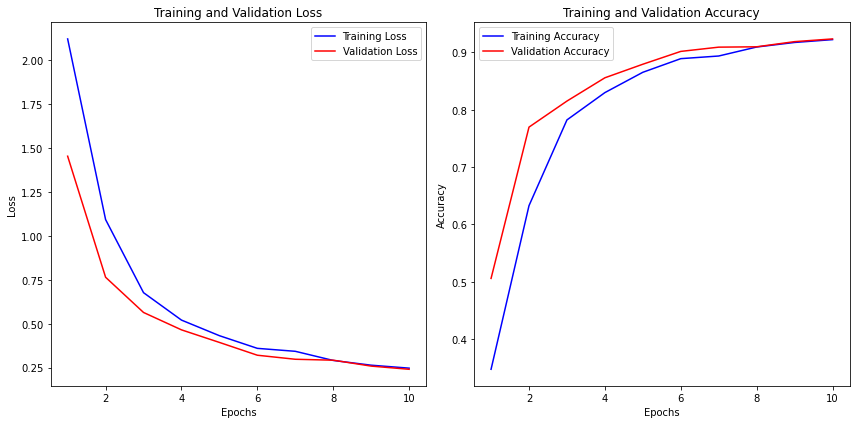

In [27]:
def plot_loss_and_accuracy(model_history):
    # Extract training and validation loss and accuracy values from the model history
    train_loss = model_history.history['loss']
    val_loss = model_history.history['val_loss']
    train_accuracy = model_history.history['accuracy']
    val_accuracy = model_history.history['val_accuracy']

    # Define the number of epochs
    epochs = range(1, len(train_loss) + 1)

    # Create subplots for loss and accuracy
    plt.figure(figsize=(12, 6))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracy, 'b', label='Training Accuracy')
    plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Ensure proper layout
    plt.tight_layout()
    plt.show()

# Call the function with your model history
plot_loss_and_accuracy(model_history1)



The results suggest that the neural network model is learning to perform well on the given task. The decreasing loss and increasing accuracy indicate that the model is improving its ability to make accurate predictions over the course of training

In [28]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

In [29]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

In [30]:
def show_predictions(dataset=None, num=1):
    """
    Displays the first image of each of the num batches
    """
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = unet.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
             create_mask(unet.predict(sample_image[tf.newaxis, ...]))])

1/1 [==============================] - 1s 997ms/step


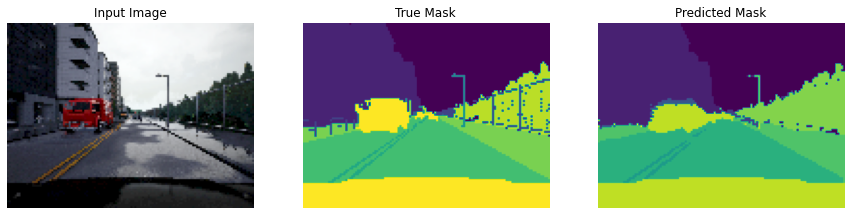

1/1 [==============================] - 1s 979ms/step


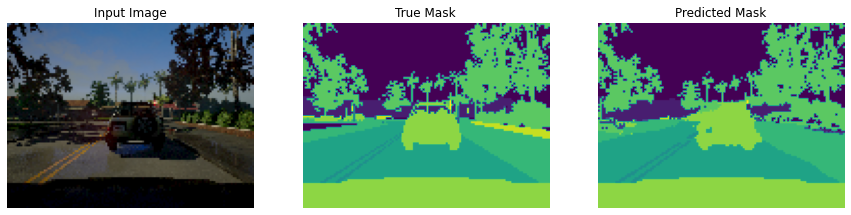

1/1 [==============================] - 1s 1s/step


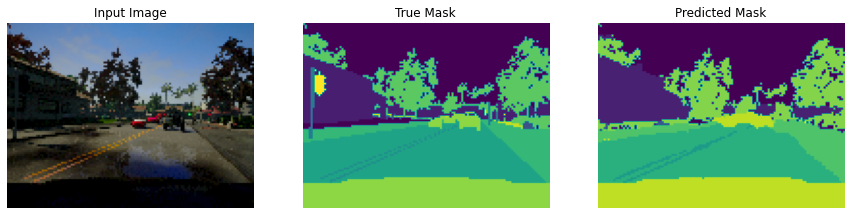

1/1 [==============================] - 1s 959ms/step


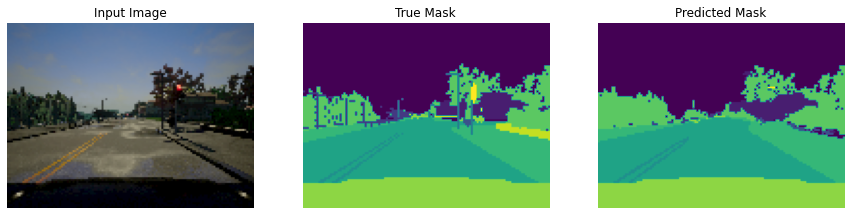

1/1 [==============================] - 1s 934ms/step


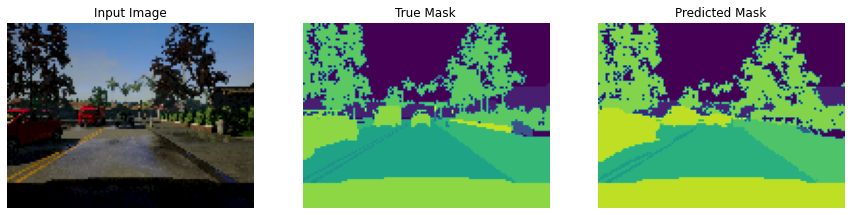

In [34]:
show_predictions(train_dataset, 5)

## Saving the Model

In [35]:
from tensorflow.keras.models import save_model

# Save the U-Net model to your specified file path
save_model(unet, 'C:/Users/Zi Han/Documents/CM3070 FYP/model.h5')
